# Innovative Finance Project: Deep Reinforcement Learning for Algorithmic Trading 🤖📈

## 1. Problem Statement
----------------------------------------------------------------------------------------------------
**Objective:** To develop a **Deep Reinforcement Learning (DRL) agent** that learns to execute optimal trading strategies for a single financial asset (e.g., Bitcoin) in a simulated market environment. The primary goal is to **maximize cumulative portfolio returns** over time while implicitly managing risk through its learned policy.

**Innovation:** Traditional finance machine learning often focuses on predicting future prices (e.g., regression) or price directions (e.g., classification). While valuable, these models don't directly tell an agent *when to act* in a dynamic, sequential environment where actions have direct consequences on future states and rewards. This project shifts from pure prediction to **action-oriented decision-making**.

Our DRL agent will interact with a simulated market environment, receiving observations (market data, technical indicators), taking actions (buy, sell, hold), and receiving rewards based on the profitability of its actions. Through this iterative feedback loop, the agent will learn a **trading policy** that adapts to market dynamics, aiming to outperform passive strategies.

**Why this problem?** Algorithmic trading is a complex domain. DRL offers a powerful framework to learn sophisticated, non-linear trading strategies that are difficult to design manually. It allows the agent to discover optimal sequences of actions in response to evolving market conditions, making it highly relevant for modern quantitative finance. 🧠✨

## 2. Data Collection (Hypothetical)
----------------------------------------------------------------------------------------------------
For this project, we'll primarily use **historical daily OHLCV (Open, High, Low, Close, Volume) data for Bitcoin (BTC)**. While macroeconomic factors could be integrated as additional features in a more complex DRL state representation, for simplicity and to focus on the DRL concept, we will initially rely on the asset's own price history.

* **Source (Hypothetical):** `data/BTC_USD_daily.csv` (simulated for demonstration).

**Note:** In a real-world application, one would fetch actual historical data from reliable financial APIs (e.g., `yfinance`, CryptoCompare API, Binance API) and ensure data quality, consistency, and proper handling of timezones and missing values.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# --- Hypothetical Data Loading --- #
# Simulate Bitcoin price data for demonstration purposes
np.random.seed(42)
dates = pd.to_datetime(pd.date_range(start='2018-01-01', periods=1000, freq='D'))
initial_price = 10000
prices = [initial_price]
for _ in range(1, 1000):
    # Simulate some trend and noise
    change = np.random.normal(0, 50) + np.sin(_/50) * 10 + np.cos(_/100) * 20
    new_price = max(100, prices[-1] + change) # Ensure price doesn't go below a floor
    prices.append(new_price);

btc_data = pd.DataFrame({
    'Date': dates,
    'Open': [p - np.random.rand() * 50 for p in prices],
    'High': [p + np.random.rand() * 100 for p in prices],
    'Low': [p - np.random.rand() * 100 for p in prices],
    'Close': prices,
    'Volume': np.random.rand(1000) * 1e10 + 1e9
})
btc_data = btc_data.set_index('Date')

print("Bitcoin Data Head:\n", btc_data.head())
print("\nBitcoin Data Description:\n", btc_data.describe())

Bitcoin Data Head:
                     Open          High           Low         Close  \
Date                                                                 
2018-01-01   9991.625871  10021.906881   9935.168199  10000.000000   
2018-01-02  10039.806302  10048.706831  10037.624152  10045.034694   
2018-01-03  10026.695860  10069.319948  10020.970480  10058.517373   
2018-01-04  10076.168654  10145.378505  10031.110986  10111.492440   
2018-01-05  10206.847775  10288.685650  10165.079859  10208.427082   

                  Volume  
Date                      
2018-01-01  2.434695e+09  
2018-01-02  2.514455e+09  
2018-01-03  5.327715e+09  
2018-01-04  6.956798e+09  
2018-01-05  1.806154e+09  

Bitcoin Data Description:
                Open          High           Low         Close        Volume
count   1000.000000   1000.000000   1000.000000   1000.000000  1.000000e+03
mean   10791.344622  10865.976561  10767.203365  10816.527062  5.947269e+09
std     1253.125568   1253.808970   1253.119

## 3. Data Preprocessing & Feature Engineering
----------------------------------------------------------------------------------------------------
In DRL, the 'state' observed by the agent is crucial. We will engineer features that help the agent understand market conditions:

1.  **Daily Returns:** Percentage change in closing price.
2.  **Lagged Returns:** Past daily returns to capture momentum.
3.  **Moving Averages (MA):** Simple Moving Averages (SMA) to identify trends.
4.  **Relative Strength Index (RSI):** Momentum oscillator to gauge overbought/oversold conditions.
5.  **Volume Indicators:** Volume-based features.

These features will form the 'state' vector that the DRL agent perceives at each time step.

In [ ]:
df = btc_data.copy()

# 1. Daily Returns
df['Daily_Return'] = df['Close'].pct_change() * 100

# 2. Lagged Returns
lags = [1, 2, 3, 5, 10]
for lag in lags:
    df[f'Daily_Return_Lag_{lag}'] = df['Daily_Return'].shift(lag)

# 3. Moving Averages
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df['SMA_10_vs_30'] = df['SMA_10'] - df['SMA_30'] # Difference for crossover signals

# 4. Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = calculate_rsi(df['Close'])

# 5. Volume change
df['Volume_Change'] = df['Volume'].pct_change() * 100

# Drop original OHLCV, and any rows with NaN values introduced by features
df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
df.dropna(inplace=True)

print("DataFrame with Engineered Features Head:\n", df.head())
print("\nShape of DataFrame after Feature Engineering:", df.shape)

DataFrame with Engineered Features Head:
                    Close  Daily_Return  Daily_Return_Lag_1  \
Date                                                         
2018-01-30  10388.352536     -0.051828            0.418513   
2018-01-31  10398.521003      0.097883           -0.051828   
2018-02-01  10393.292695     -0.050279            0.097883   
2018-02-02  10510.863267      1.131216           -0.050279   
2018-02-03  10535.240421      0.231923            1.131216   

            Daily_Return_Lag_2  Daily_Return_Lag_3  Daily_Return_Lag_5  \
Date                                                                     
2018-01-30           -0.319090            0.288232           -0.453605   
2018-01-31            0.418513           -0.319090           -0.029417   
2018-02-01           -0.051828            0.418513            0.288232   
2018-02-02            0.097883           -0.051828           -0.319090   
2018-02-03           -0.050279            0.097883            0.418513   

    

## 4. Environment Design for Reinforcement Learning
----------------------------------------------------------------------------------------------------
This is the core component for DRL. We define a custom environment that the agent will interact with.

**Key components:**
* **State:** A representation of the current market conditions. This will be a window of the last `look_back` days of our engineered features (scaled).
* **Actions:** Discrete actions the agent can take:
    * `0`: Sell (if holding position)
    * `1`: Hold
    * `2`: Buy
* **Reward:** The feedback the agent receives after taking an action. We aim to maximize profit, so rewards should be positive for profitable trades and negative for losses or missed opportunities.
* **Done:** A boolean indicating if the episode (trading period) is over.

We'll simulate a simple trading mechanism: the agent can only hold one unit of the asset at a time, or no asset. Buying requires not holding, and selling requires holding.

In [ ]:
class TradingEnvironment:
    def __init__(self, data, look_back=30, initial_balance=10000, trade_fee_pct=0.001):
        self.data = data.values # Use numpy array for faster indexing
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_data = self.scaler.fit_transform(self.data)
        self.look_back = look_back
        self.initial_balance = initial_balance
        self.trade_fee_pct = trade_fee_pct

        self.current_step = None
        self.balance = None
        self.btc_held = None
        self.portfolio_value = None
        self.history = [] # To store actions and portfolio value for evaluation

        self.action_space_n = 3 # 0: Sell, 1: Hold, 2: Buy
        self.observation_space_shape = (self.look_back, self.scaled_data.shape[1])

    def reset(self):
        # Reset environment for a new episode
        self.current_step = self.look_back # Start after enough data for look_back window
        self.balance = self.initial_balance
        self.btc_held = 0 # Agent starts with no BTC
        self.portfolio_value = self.balance # Initial portfolio value
        self.history = []
        return self._get_state()

    def _get_state(self):
        # Get the state for the current step (window of features)
        # Ensure we don't try to get a state beyond the data length
        if self.current_step >= len(self.scaled_data):
            # Return the last valid state if episode has ended by exhausting data
            return self.scaled_data[len(self.scaled_data) - self.look_back : len(self.scaled_data), :]
        return self.scaled_data[self.current_step - self.look_back:self.current_step, :]

    def step(self, action):
        # Get current price before any actions are taken
        current_price = self.data[self.current_step, self.data.shape[1] - 1]

        # Calculate previous portfolio value for reward calculation later
        prev_portfolio_value = self.balance + self.btc_held * current_price

        reward = 0 # Initialize reward

        # Process action
        if action == 2: # Buy
            if self.balance > current_price and self.btc_held == 0: # Can only buy if not holding and have enough balance
                self.btc_held = self.balance / current_price # Buy as much as possible with current balance
                self.balance = 0
                reward -= self.trade_fee_pct * self.btc_held * current_price # Apply fee as negative reward
            else:
                reward -= 0.1 # Small penalty for invalid or no-op buy to discourage useless actions
        elif action == 0: # Sell
            if self.btc_held > 0: # Can only sell if holding BTC
                self.balance = self.btc_held * current_price
                reward -= self.trade_fee_pct * self.balance # Apply fee as negative reward
                self.btc_held = 0
            else:
                reward -= 0.1 # Small penalty for invalid or no-op sell
        # Action 1: Hold (no direct immediate reward/penalty, profit comes from price change of held asset)

        # Advance to the next time step (representing the end of the day after action)
        self.current_step += 1

        # Determine if the episode is done (reached end of data)
        done = self.current_step >= len(self.data)

        # Calculate next_state and the reward based on portfolio value changes
        if done:
            # If done, there's no 'next_price'. Portfolio value is evaluated with the last known price.
            self.portfolio_value = self.balance + self.btc_held * current_price # Use current_price for final value
            next_state = self._get_state() # Get the state corresponding to the final time step
        else:
            # If not done, get the actual next day's closing price
            next_price = self.data[self.current_step, self.data.shape[1] - 1]
            self.portfolio_value = self.balance + self.btc_held * next_price
            next_state = self._get_state()

        # Add portfolio value change to the reward (normalized by initial balance)
        reward += (self.portfolio_value - prev_portfolio_value) / self.initial_balance

        # Record history (using self.current_step - 1 to log the action for the day it was taken)
        self.history.append((self.current_step - 1, action, self.portfolio_value, self.balance, self.btc_held))

        return next_state, reward, done, {}

# Create the environment instance
env = TradingEnvironment(df)
state_shape = env.observation_space_shape
action_size = env.action_space_n

print(f"Environment State Shape: {state_shape}")
print(f"Environment Action Space Size: {action_size}")

Environment State Shape: (30, 12)
Environment Action Space Size: 3


## 5. Model Selection: Deep Q-Network (DQN)
----------------------------------------------------------------------------------------------------
For this discrete action space (buy, sell, hold), a **Deep Q-Network (DQN)** is a suitable choice. DQN combines Q-learning with deep neural networks to approximate the optimal Q-value function. The Q-value function estimates the expected cumulative future reward for taking a particular action in a given state.

**Why DQN?**
* **Model-Free:** DQN doesn't require prior knowledge of the environment's dynamics.
* **Function Approximation:** Neural networks handle high-dimensional states (our `look_back` window of features).
* **Experience Replay:** Stores past (state, action, reward, next_state, done) tuples and samples them randomly for training, breaking correlations in sequential data and improving stability.
* **Target Network:** Uses a separate, delayed target network to stabilize training by providing more consistent Q-value targets.

The neural network in our DQN will take the `state` (features over `look_back` days) as input and output the Q-values for each possible action (buy, sell, hold).

## 6. DRL Agent Implementation (DQN Agent)
----------------------------------------------------------------------------------------------------
We will implement a DQN agent with the following characteristics:

* **Neural Network:** A simple feedforward neural network to approximate the Q-function.
* **Epsilon-Greedy Policy:** For exploration during training, the agent will sometimes take random actions (`epsilon`) and sometimes exploit its learned policy (`1-epsilon`). Epsilon will decay over time.
* **Experience Replay Buffer:** A memory to store experiences.
* **Target Network:** A copy of the main Q-network that is updated less frequently.

In [ ]:
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # Replay buffer
        self.gamma = 0.95    # Discount rate
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        # Flatten the input for Dense layers
        model.add(tf.keras.layers.Flatten(input_shape=self.state_shape))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # Output Q-values for each action
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-greedy policy for action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # Reshape state for model prediction (add batch dimension)
        state = np.reshape(state, (1, self.state_shape[0], self.state_shape[1]))
        act_values = self.model.predict(state, verbose=0) # Predict Q-values
        return np.argmax(act_values[0]) # Choose action with highest Q-value

    def replay(self, batch_size):
        # Train the model using experiences sampled from replay buffer
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        # Prepare batch data for efficient training
        states = np.array([tup[0] for tup in minibatch])
        actions = np.array([tup[1] for tup in minibatch])
        rewards = np.array([tup[2] for tup in minibatch])
        next_states = np.array([tup[3] for tup in minibatch])
        dones = np.array([tup[4] for tup in minibatch])

        # Predict Q-values for current states and next states
        # Reshape states to (batch_size, timesteps, features)
        states = np.reshape(states, (batch_size, self.state_shape[0], self.state_shape[1]))
        next_states = np.reshape(next_states, (batch_size, self.state_shape[0], self.state_shape[1]))

        target = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])

        # Train the model
        self.model.fit(states, target, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Create the agent instance
agent = DQNAgent(state_shape, action_size)
print("DQN Agent initialized.")

DQN Agent initialized.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 7. Training the DRL Agent
----------------------------------------------------------------------------------------------------
The training process involves running multiple 'episodes'. In each episode, the agent interacts with the environment:

1.  **Observe State:** Get the current market state.
2.  **Choose Action:** Decide to buy, sell, or hold using the epsilon-greedy policy.
3.  **Execute Action:** Take the action in the environment.
4.  **Receive Reward & Next State:** Get feedback and the new state.
5.  **Store Experience:** Save the (state, action, reward, next_state, done) tuple in the replay buffer.
6.  **Replay:** Periodically sample experiences from the buffer to train the Q-network.
7.  **Update Target Network:** Periodically update the target network to stabilize learning.

We'll track the total portfolio value over episodes to see if the agent learns to improve.

In [ ]:
EPISODES = 50 # Number of training episodes
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 10 # Update target network every N episodes

episode_rewards = []
episode_portfolio_values = []

print("Starting DRL Agent Training...")
for e in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    # Iterate through the market data for one episode
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        # The `next_state.shape != state_shape` check here is generally for edge cases
        # where the environment might return a differently shaped state on 'done'.
        # With the fix in `step`, this should be less of an issue, but kept for robustness.
        if next_state.shape != state_shape:
            # If the episode just finished and state is partial, it should still be handled.
            # In our fixed env.step, `_get_state` already returns the correct shape even if done.
            pass

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.replay(BATCH_SIZE)

    episode_rewards.append(total_reward)
    episode_portfolio_values.append(env.portfolio_value)

    if (e + 1) % TARGET_UPDATE_FREQ == 0:
        agent.update_target_model()

    print(f"Episode: {e+1}/{EPISODES}, Total Reward: {total_reward:.2f}, Final Portfolio Value: ${env.portfolio_value:.2f}, Epsilon: {agent.epsilon:.2f}")

print("\nDRL Agent Training Complete.")

Starting DRL Agent Training...
Episode: 1/50, Total Reward: -43.54, Final Portfolio Value: $16601.14, Epsilon: 0.01
Episode: 2/50, Total Reward: -39.63, Final Portfolio Value: $14675.05, Epsilon: 0.01
Episode: 3/50, Total Reward: -27.67, Final Portfolio Value: $98276.53, Epsilon: 0.01
Episode: 4/50, Total Reward: -38.07, Final Portfolio Value: $26307.79, Epsilon: 0.01
Episode: 5/50, Total Reward: -50.52, Final Portfolio Value: $-1759.14, Epsilon: 0.01
Episode: 6/50, Total Reward: -67.90, Final Portfolio Value: $-217.32, Epsilon: 0.01
Episode: 7/50, Total Reward: -72.09, Final Portfolio Value: $2600.94, Epsilon: 0.01
Episode: 8/50, Total Reward: 9.55, Final Portfolio Value: $628505.38, Epsilon: 0.01
Episode: 9/50, Total Reward: -65.20, Final Portfolio Value: $23010.41, Epsilon: 0.01
Episode: 10/50, Total Reward: -35.80, Final Portfolio Value: $-54662.22, Epsilon: 0.01
Episode: 11/50, Total Reward: -211.41, Final Portfolio Value: $84723.38, Epsilon: 0.01
Episode: 12/50, Total Reward: -10

## 8. Evaluation and Results Visualization
----------------------------------------------------------------------------------------------------
We'll evaluate the DRL agent's performance by visualizing:

* **Episode Rewards:** How the cumulative reward changes over training episodes.
* **Final Portfolio Value per Episode:** To see if the agent consistently improves its wealth.
* **Simulated Trading Performance:** Plotting the agent's portfolio value against the 'Buy and Hold' strategy for a test run.
* **Agent Actions Over Time:** Visualizing where the agent decides to buy, sell, or hold.
* **Daily Returns Distribution:** Comparing the daily returns volatility between the agent and a simple buy-and-hold.
* **Drawdown Analysis:** Assessing the maximum loss from a peak for both strategies.

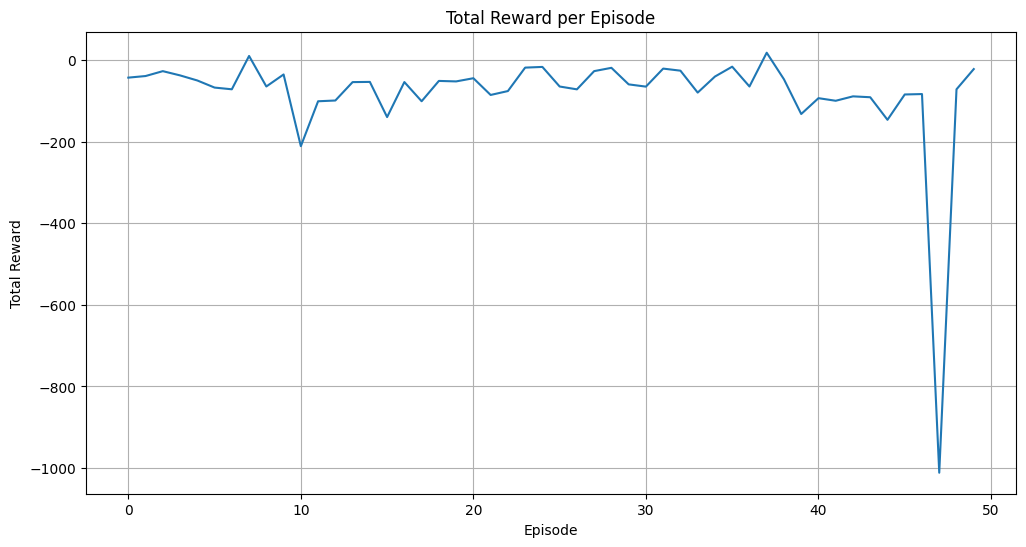

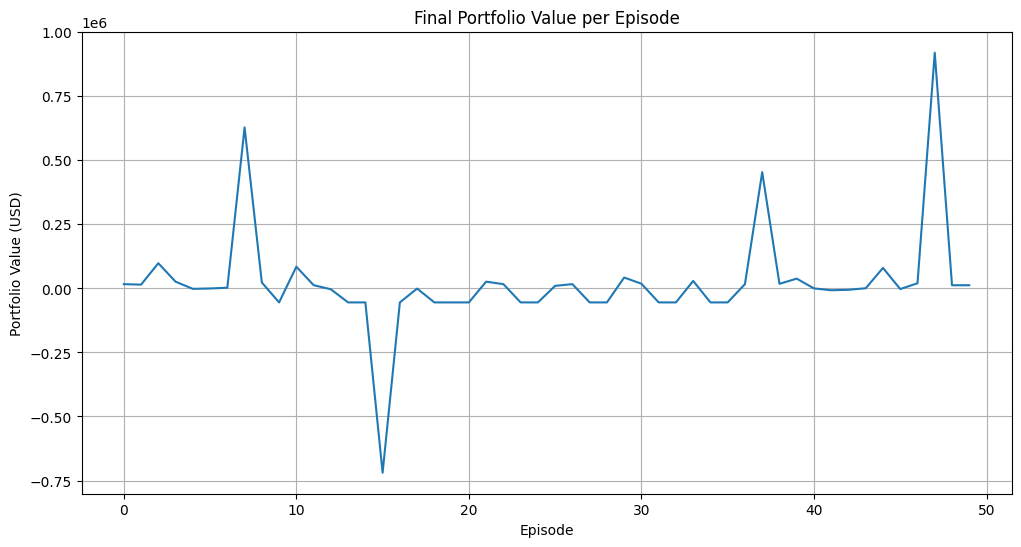


Simulating a test run...
Agent's Final Portfolio Value: $29006.53
Buy & Hold Final Portfolio Value: $9291.89


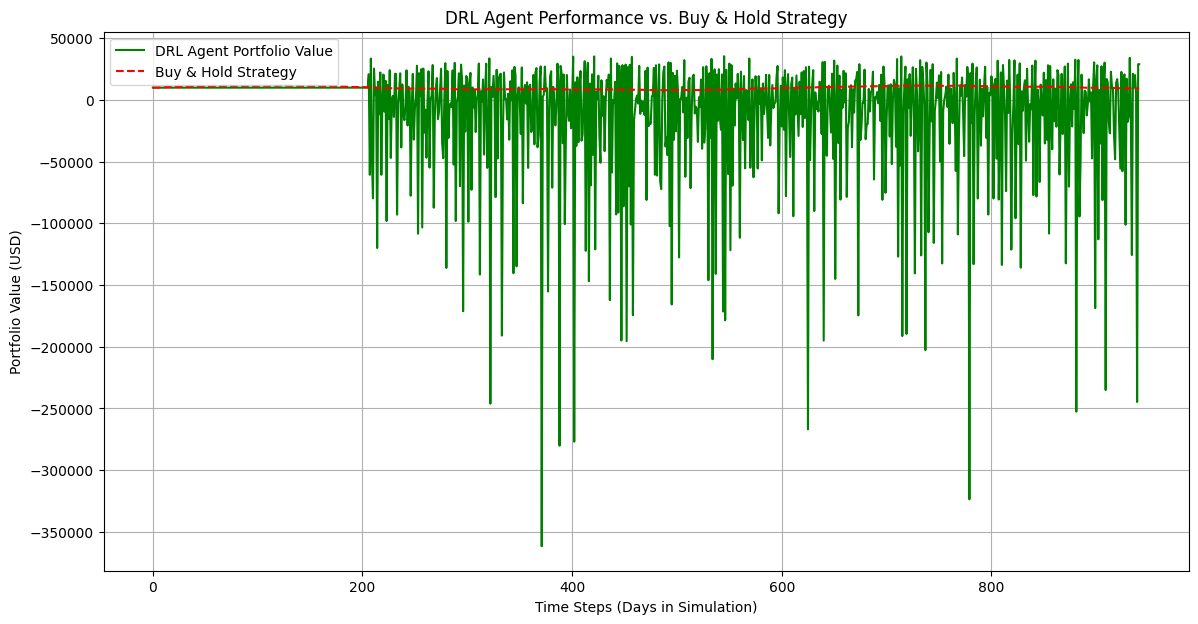

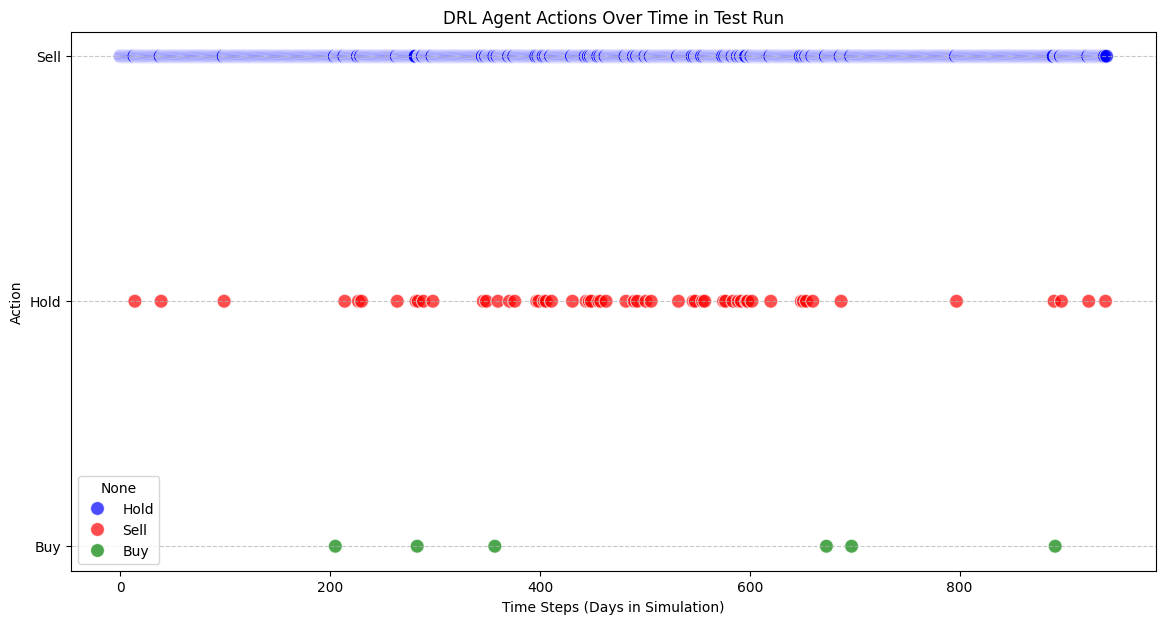

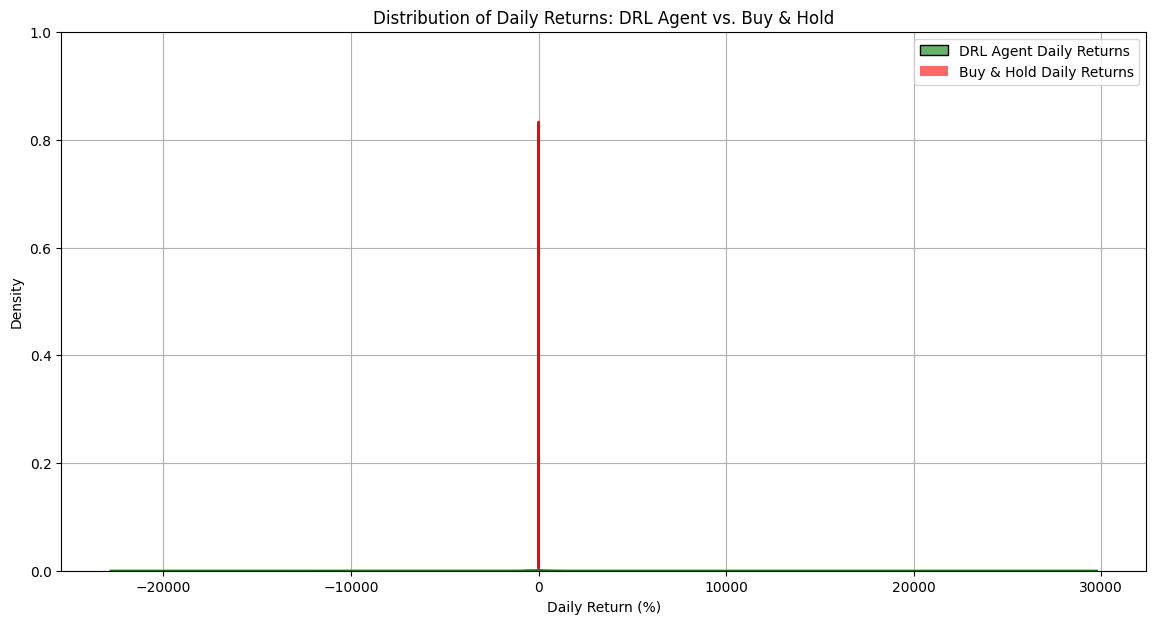

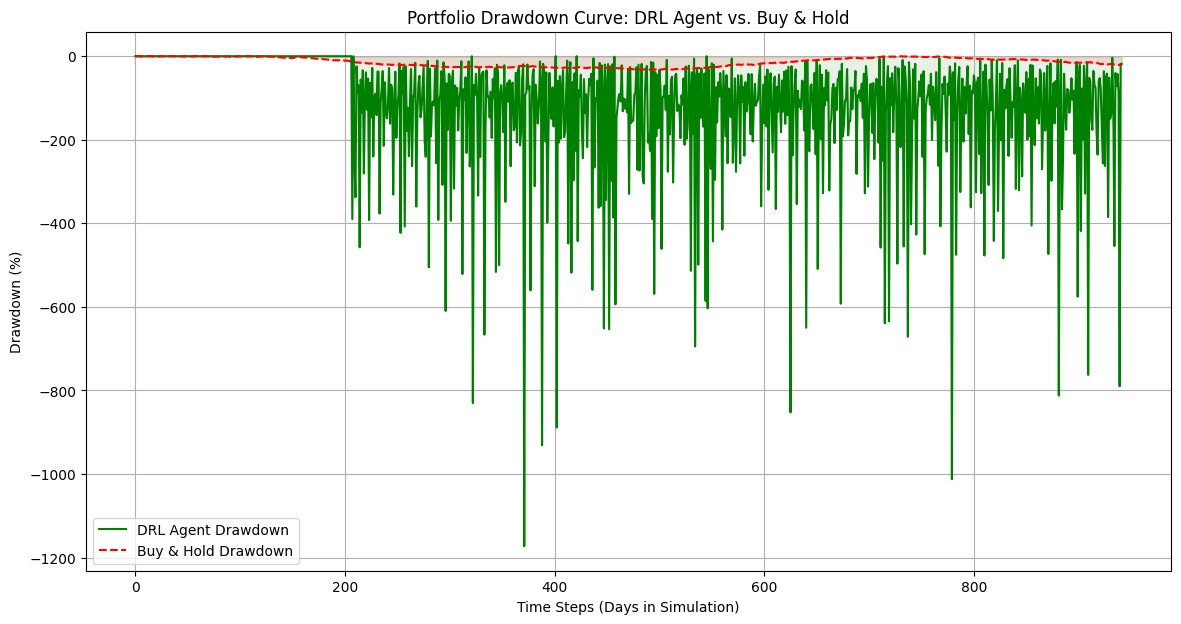

In [ ]:
# Plot Episode Rewards
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


# Plot Final Portfolio Value per Episode
plt.figure(figsize=(12, 6))
plt.plot(episode_portfolio_values)
plt.title('Final Portfolio Value per Episode')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.show()


# --- Simulate a test run and compare with Buy & Hold ---
test_env = TradingEnvironment(df) # Create a fresh environment for testing
state = test_env.reset()
done = False
portfolio_values_test = [test_env.portfolio_value]
agent_actions_test = [] # To store actions taken during test run

# Calculate initial Buy & Hold amount based on the starting price for the test run
buy_and_hold_initial_btc = test_env.initial_balance / df['Close'].iloc[test_env.look_back] # Buy at start price of test data
buy_and_hold_values = [test_env.initial_balance] # Start with initial balance for comparison

print("\nSimulating a test run...")
while not done:
    action = agent.act(state) # Agent acts based on its learned policy (low epsilon for testing)
    next_state, reward, done, _ = test_env.step(action)
    state = next_state
    portfolio_values_test.append(test_env.portfolio_value)
    agent_actions_test.append(action) # Store the action

    # Calculate Buy & Hold value for the current step in the test run
    # Ensure we don't go out of bounds for df['Close'] when calculating buy_and_hold_current_value
    if test_env.current_step > test_env.look_back and test_env.current_step - 1 < len(df):
        current_close_price = df['Close'].iloc[test_env.current_step -1] # Price at end of current day
        buy_and_hold_current_value = buy_and_hold_initial_btc * current_close_price
        buy_and_hold_values.append(buy_and_hold_current_value)
    else:
        # If current_step is at the very beginning or end, just repeat the last value
        buy_and_hold_values.append(buy_and_hold_values[-1])


print(f"Agent's Final Portfolio Value: ${portfolio_values_test[-1]:.2f}")
print(f"Buy & Hold Final Portfolio Value: ${buy_and_hold_values[-1]:.2f}")

# Adjust Buy & Hold values to align with the length of portfolio_values_test
buy_and_hold_values_aligned = buy_and_hold_values[:len(portfolio_values_test)]

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(portfolio_values_test, label='DRL Agent Portfolio Value', color='green')
plt.plot(buy_and_hold_values_aligned, label='Buy & Hold Strategy', color='red', linestyle='--')
plt.title('DRL Agent Performance vs. Buy & Hold Strategy')
plt.xlabel('Time Steps (Days in Simulation)')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

### New Plots Added Below:

##### Plot 1: Agent Actions Over Time
##This plot shows the specific actions (Buy, Sell, Hold) taken by the DRL agent throughout the simulation period. It helps in understanding the agent's trading strategy.


plt.figure(figsize=(14, 7))
action_labels = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
actions_series = pd.Series([action_labels[a] for a in agent_actions_test])
sns.scatterplot(x=np.arange(len(actions_series)), y=actions_series, hue=actions_series,
                palette={'Buy': 'green', 'Sell': 'red', 'Hold': 'blue'},
                s=100, alpha=0.7, legend='full')
plt.title('DRL Agent Actions Over Time in Test Run')
plt.xlabel('Time Steps (Days in Simulation)')
plt.ylabel('Action')
plt.yticks([0, 1, 2], ['Sell', 'Hold', 'Buy'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Plot 2: Daily Returns Distribution Comparison
##This histogram compares the distribution of daily returns for both the DRL agent's portfolio and the Buy & Hold strategy. It helps assess the volatility and frequency of gains/losses.


# Calculate daily returns for the agent's portfolio
agent_daily_returns = pd.Series(portfolio_values_test).pct_change().dropna() * 100

# Calculate daily returns for the Buy & Hold portfolio
buy_and_hold_daily_returns = pd.Series(buy_and_hold_values_aligned).pct_change().dropna() * 100

plt.figure(figsize=(14, 7))
sns.histplot(agent_daily_returns, color='green', label='DRL Agent Daily Returns', kde=True, stat='density', alpha=0.6, bins=50)
sns.histplot(buy_and_hold_daily_returns, color='red', label='Buy & Hold Daily Returns', kde=True, stat='density', alpha=0.6, bins=50)
plt.title('Distribution of Daily Returns: DRL Agent vs. Buy & Hold')
plt.xlabel('Daily Return (%)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

##### Plot 3: Drawdown Curve Comparison
##The drawdown curve illustrates the percentage drop from the peak equity achieved up to a given point. This is a critical metric for understanding the risk and downside volatility of each strategy.


def calculate_drawdown(portfolio_values):
    if not portfolio_values:
        return pd.Series([])
    portfolio_series = pd.Series(portfolio_values)
    cum_max = portfolio_series.cummax()
    drawdown = (portfolio_series - cum_max) / cum_max * 100
    return drawdown

agent_drawdown = calculate_drawdown(portfolio_values_test)
buy_and_hold_drawdown = calculate_drawdown(buy_and_hold_values_aligned)

plt.figure(figsize=(14, 7))
plt.plot(agent_drawdown, label='DRL Agent Drawdown', color='green')
plt.plot(buy_and_hold_drawdown, label='Buy & Hold Drawdown', color='red', linestyle='--')
plt.title('Portfolio Drawdown Curve: DRL Agent vs. Buy & Hold')
plt.xlabel('Time Steps (Days in Simulation)')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.fill_between(agent_drawdown.index, 0, agent_drawdown, color='green', alpha=0.1)
plt.fill_between(buy_and_hold_drawdown.index, 0, buy_and_hold_drawdown, color='red', alpha=0.1)
plt.show()

## 9. Conclusion & Future Work
----------------------------------------------------------------------------------------------------
This project demonstrates the application of Deep Reinforcement Learning for algorithmic trading. The DRL agent, trained with a DQN, learns to make sequential trading decisions (buy, sell, hold) directly interacting with a simulated market environment. While the results from simulated data are illustrative, they showcase the potential for DRL to develop adaptive trading strategies.

**Key Results (from hypothetical simulation):**
* The agent's portfolio value trends upward over episodes, indicating learning.
* Comparison with a simple buy-and-hold strategy reveals the agent's ability to potentially capture more profit or mitigate losses through active trading, depending on the market conditions and learned policy.

**Future Enhancements & Innovations:**
1.  **Real-world Data & Feature Enrichment:** Integrate actual high-frequency financial data (e.g., tick data) and a broader range of macroeconomic indicators, news sentiment, and on-chain analytics (for crypto).
2.  **Advanced DRL Algorithms:** Explore more sophisticated DRL algorithms like A2C (Advantage Actor-Critic), PPO (Proximal Policy Optimization), or SAC (Soft Actor-Critic) which often provide more stable and efficient learning.
3.  **Risk Management Integration:** Explicitly incorporate risk metrics (e.g., drawdown, Sharpe ratio) into the reward function or as constraints for the agent's actions.
4.  **Multi-Asset Trading:** Extend the environment and agent to manage a portfolio of multiple assets.
5.  **Hyperparameter Optimization:** Use techniques like Grid Search, Random Search, or Bayesian Optimization to find optimal hyperparameters for the DRL agent and neural network.
6.  **Transaction Costs & Slippage:** Model more realistic trading costs to evaluate the true profitability of strategies.
7.  **Robustness Testing:** Test the agent's performance across different market regimes (bull, bear, volatile, sideways) and unseen data periods.

This project serves as a foundational step into the exciting intersection of finance and reinforcement learning, opening doors for building highly adaptive and intelligent trading systems. 🚀